# Spatio-Temporal Data Clustering

In [61]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN

import geopandas as gpd
import osmnx as ox
from st_dbscan import ST_DBSCAN
from shapely import wkt

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
import folium
from folium.plugins import HeatMap, HeatMapWithTime

# Benchmarking
from time import time

In [2]:
# Import data
stps = pd.read_csv('../../trackintel/20190601_stps.csv')
stps['geom'] = stps['geom'].apply(wkt.loads)
stps = gpd.GeoDataFrame(stps)

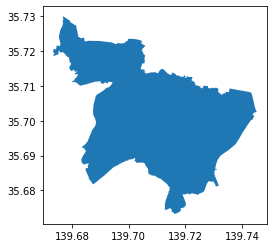

In [3]:
# Filter points for Shinjuku-ku
shinjuku = ox.geocode_to_gdf('Shinjuku')
shinjuku_mask = stps['geom'].map(lambda x: x.within(shinjuku['geometry'].values[0]))
stps = stps[shinjuku_mask]

shinjuku.plot() # Check
plt.show()

In [104]:
# Preprocessing
stps['lat'] = stps['geom'].map(lambda point: point.y)
stps['lon'] = stps['geom'].map(lambda point: point.x)
stps['started_at'] = pd.to_datetime(stps['started_at'])
stps['finished_at'] = pd.to_datetime(stps['finished_at'])
stps['start_hour'] = stps['started_at'].map(lambda x: x.hour)
stps['start_at_str'] = stps['started_at'].map(lambda x: x.strftime('%a, %Y/%m/%d, %I %p'))
stps['duration'] = stps['finished_at'] - stps['started_at']
stps['duration'] = stps['duration'].map(lambda x: x.seconds/60)

stps = stps[stps['duration'] > 30]

In [105]:
def getDistanceByHaversine(loc1, loc2, radius = 6371.0):
    '''Haversine formula - give coordinates as a 2D numpy array of
    (lat_denter link description hereecimal,lon_decimal) pairs'''
    
    # "unpack" our numpy array, this extracts column wise arrays
    loc1 = np.radians(loc1)
    loc2 = np.radians(loc2)

    # convert to radians ##### Completely identical
    lon1, lat1 = loc1[0], loc1[1]
    lon2, lat2 = loc2[0], loc2[1]
    
    # haversine formula #### Same, but atan2 named arctan2 in numpy
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (np.sin(dlat/2))**2 + np.cos(lat1) * np.cos(lat2) * (np.sin(dlon/2.0))**2
    c = 2.0 * np.arctan2(np.sqrt(a), np.sqrt(1.0-a))
    km = radius * c

    return km

In [106]:
X = stps.loc[:,['lat','lon']].to_numpy()
X.shape

(2143, 2)

In [107]:
X = stps.loc[:,['duration','lat','lon']].to_numpy()
time_dist = pdist(X[:,0].reshape(len(X), 1))
euc_dist = pdist(X[:,1:], lambda u, v: getDistanceByHaversine(u,v))

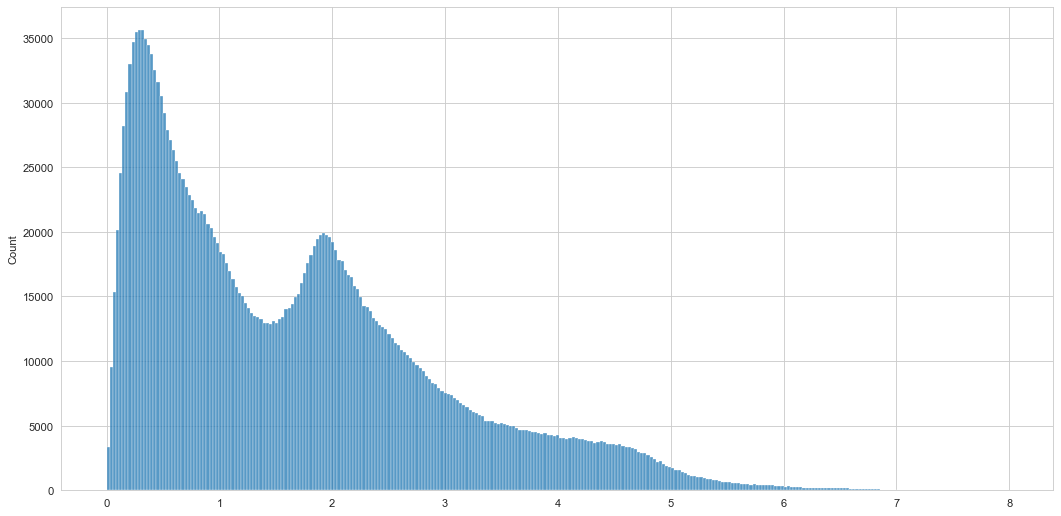

In [108]:
plt.figure(figsize=(16,8), dpi=80)
sns.histplot(euc_dist)
plt.show()

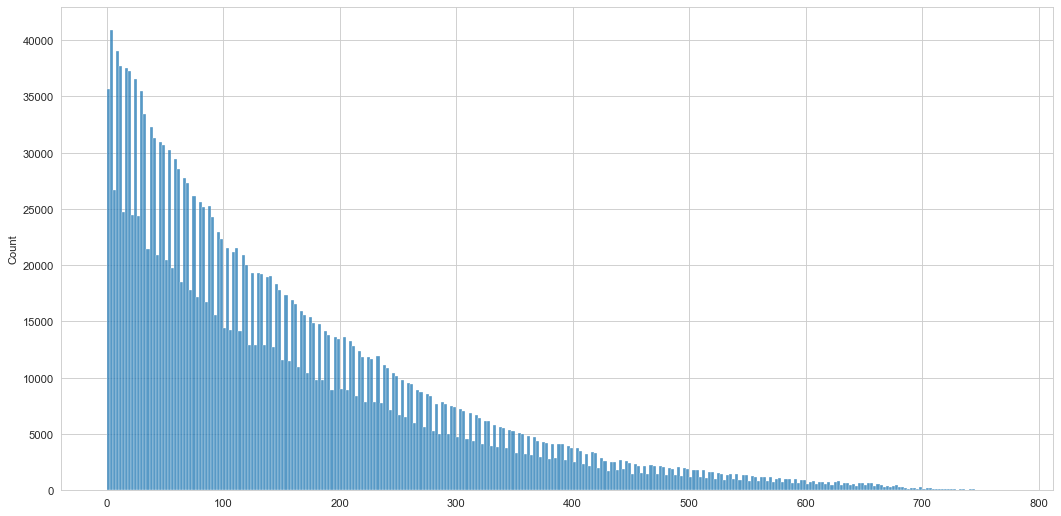

In [109]:
plt.figure(figsize=(16,8), dpi=80)
sns.histplot(time_dist)
plt.show()

In [127]:
dist = np.where(time_dist <= 60, euc_dist, 2 * 0.2)

In [132]:
db = DBSCAN(
    eps=0.2,
    min_samples=11,
    metric='precomputed'
)
db.fit(squareform(dist))

DBSCAN(eps=0.2, metric='precomputed', min_samples=11)

In [133]:
np.unique(db.labels_)

array([-1,  0,  1,  2,  3,  4,  5])

In [134]:
colordict = {
    -1: 'gray',
    0: 'blue',
    1: 'lightred',
    2: 'green',
    3: 'orange',
    4: 'pink',
    5: 'purple'
}

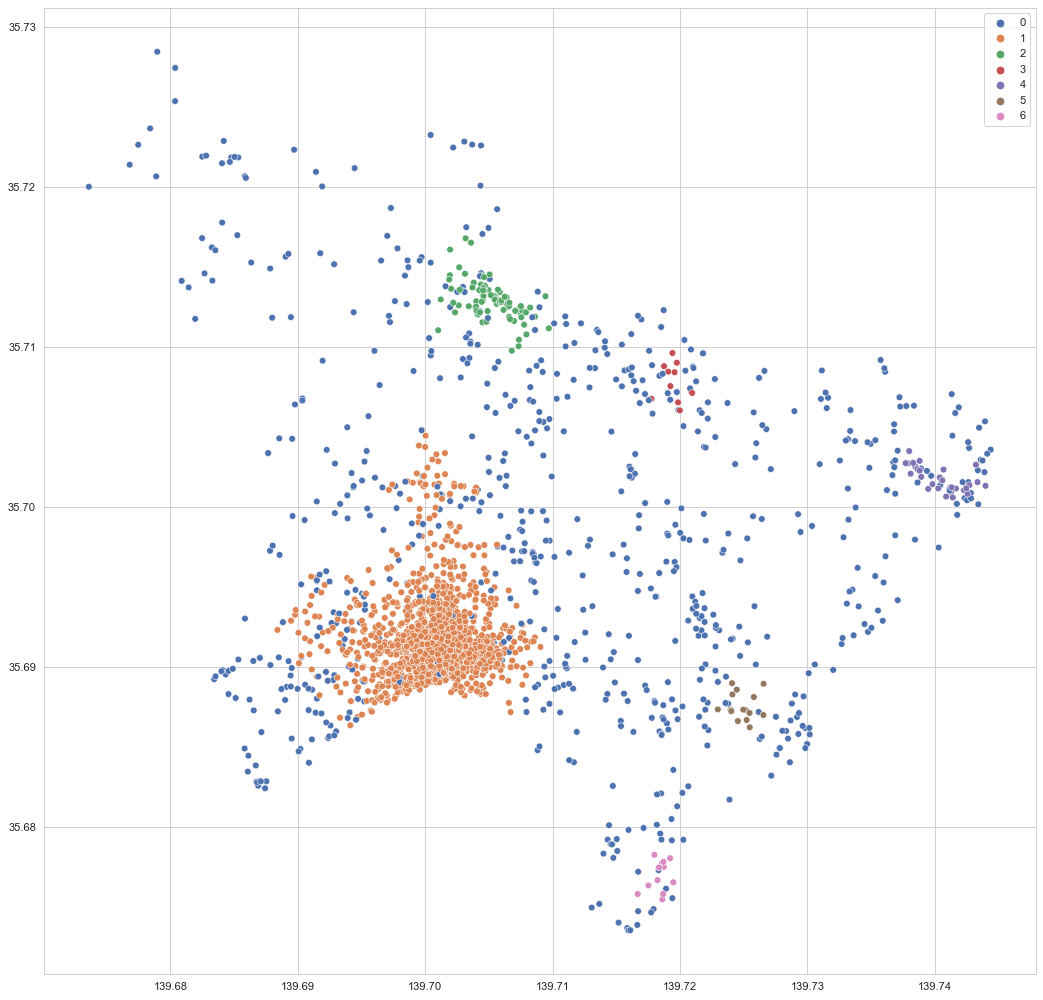

In [135]:
plt.figure(figsize=(16,16), dpi=80)
sns.scatterplot(X[:,2], X[:,1], hue = db.labels_ + 1, palette='deep')
plt.show()

In [136]:
Map = folium.Map(
    location = [35.69664542402705, 139.7031901721674], # Shijuku
    zoom_start = 12
)

for loc, lab in zip(stps.loc[:,['lat', 'lon']].values, db.labels_):
    folium.CircleMarker(
        location = loc,
        radius = 5,
        color = 'b',
        fill_color = colordict[lab],
        fill = True,
        fill_opacity = 0.7
    ).add_to(Map)

Map

In [54]:
stps['cluster'] = db.labels_

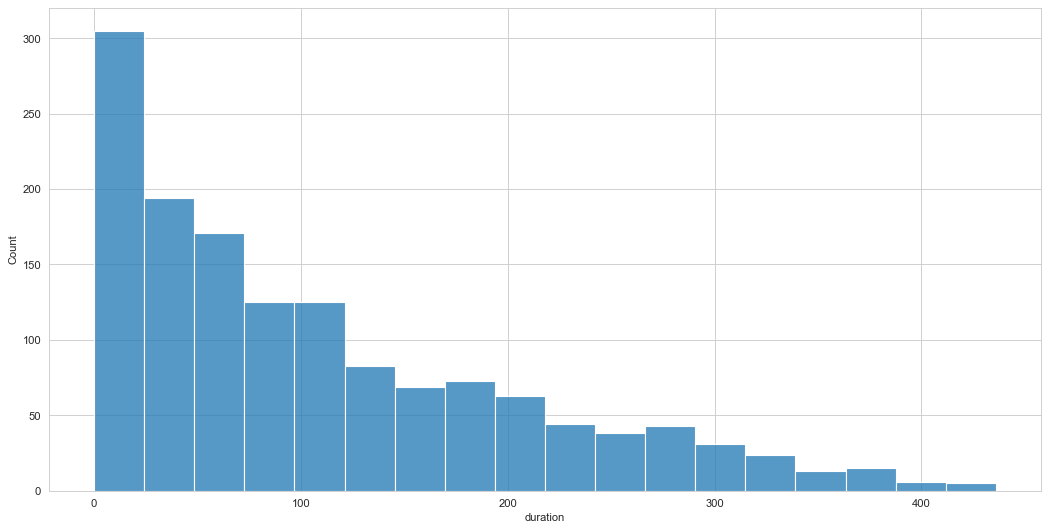

In [101]:
cluster = stps[stps['cluster'] == 0]
plt.figure(figsize=(16,8), dpi=80)
sns.histplot(cluster['duration'])
plt.show()

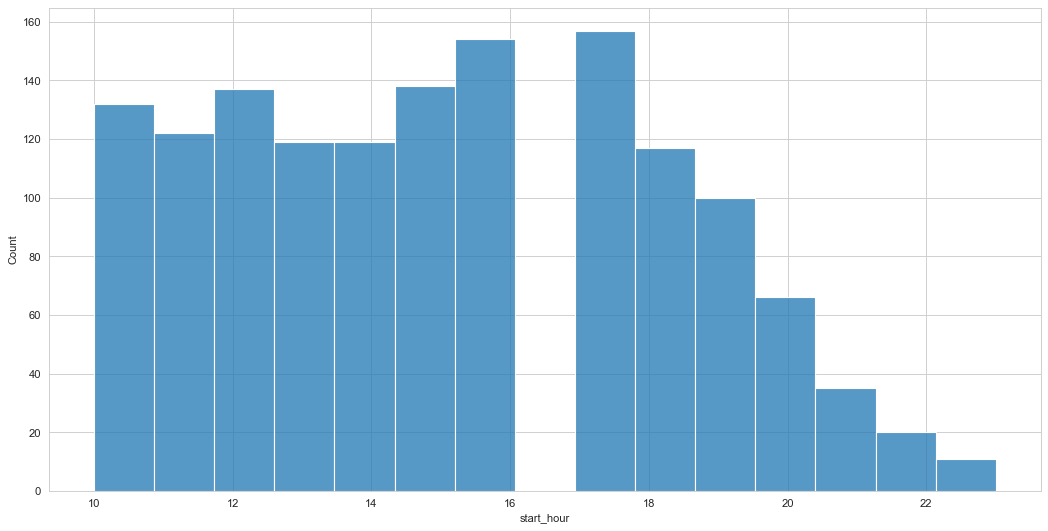

In [103]:
cluster = stps[stps['cluster'] == 0]
plt.figure(figsize=(16,8), dpi=80)
sns.histplot(cluster['start_hour'])
plt.show()